<a href="https://colab.research.google.com/github/olexandr7/erm_workshop/blob/main/ERM_workshop_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Workshop 1** is focused on trying out textual manipulation

Let's now pick a museum collection from MuIS and try several operations:
* loading all items from collection
* making a word cloud out of item titles
* exporting collection to Excel

**Block 1**: installing relevant libraries for textual manipulation
(more context needed, what exactly are libraries for)

In [13]:
#RDF scripts taken from rdflib tutorial:
#https://rdflib.readthedocs.io/en/stable/gettingstarted.html#a-more-extensive-example
#-------------------------------
#installing rdflib library
%pip install rdflib
#-------------------------------
import matplotlib.pyplot as plt
import pandas as pd
from rdflib import Graph
from wordcloud import WordCloud
#downloading files from Colab
from google.colab import files

**Block 2**: Displaying details of MuIS item in RDF
<br>  <font color='orange'>Action point:</font> Try changing URL to any other item from MUiS - there's a *püsiviide/permalink* for each item in UI
https://www.muis.ee/museaalview/1887998 -> https://opendata.muis.ee/object/1887998

In [14]:
# Create a Graph
g = Graph()
#this item could be viewed from MuIS UI via: https://www.muis.ee/museaalview/1887998
# Parse in an RDF file hosted on the Internet
g.parse("https://opendata.muis.ee/object/1887998")         #<---  URL could be changed to any item from MuIS
#displaying RDF contents - details about specific item
for s, p, o in g:
    print(s, p, o)
#Print out the entire Graph in the RDF Turtle format (added as just another example)
#print(g.serialize(format='turtle'))

http://opendata.muis.ee/object/1887998 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.cidoc-crm.org/cidoc-crm/E18_Physical_Thing
Nfdc3a7c1d47840e3a7aa6a6b7151ad2f http://www.cidoc-crm.org/cidoc-crm/P3_has_note valge, helesinine
N6c99d1a3fc204e89a1cea1573351dfdb http://www.cidoc-crm.org/cidoc-crm/P130_shows_features_of http://opendata.muis.ee/thesaurus/107/5398
http://opendata.muis.ee/object/1887998 http://www.cidoc-crm.org/cidoc-crm/P12_occurred_in_the_presence_of http://opendata.muis.ee/event/3919445
http://opendata.muis.ee/object/1887998 http://www.cidoc-crm.org/cidoc-crm/P2_has_type http://opendata.muis.ee/thesaurus/203/15633
http://opendata.muis.ee/object/1887998 http://www.w3.org/2000/01/rdf-schema#label Meeste kampsun / Jakk
N2742aabbe3fe4a76a82b8401992fdba6 http://www.cidoc-crm.org/cidoc-crm/P3_has_note villane
Ne293660a0a344b9eaf7dce668dd72e2c http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.cidoc-crm.org/cidoc-crm/E54_Dimension
N2742aabbe3fe4a76a82b840199

👕👕👕👕👕👕👕👕👕👕👕👕👕👕👕👕👕
<br>
**Dataset**: textile collection (Muuseumikogu: tekstiil) from Tallinna Linnamuuseum
<br>
http://www.muis.ee/rdf/collection/837
(change to bricks collection)
(why bricks - bricks load quicker)
(some examples here - where to get collection URL from exactly for people to test out later / in MuIS)


(seems like we also need to have limit on items of collection - so that we could load only like 50 first items)
(we could also try to have some other subsets, perhaps also on age/period of items)
(so yeah, let's have couple of filters on which items are loaded) - first 50 and also some historical periods

<br>
👕👕👕👕👕👕👕👕👕👕👕👕👕👕👕👕👕

---

**Block 3**: Loading all items from textile collection into a list
<br>  <font color='orange'>Action point:</font> Try changing URL to a different MuIS collection
(also show people how to change filters / add modifiers)
(let's also have filters in here)

In [15]:
g = Graph()
collectionitemslist = []

# Parse in an RDF file
g.parse("http://www.muis.ee/rdf/collection/849")    #<---  URL could be changed to any collection from MuIS
#http://www.muis.ee/rdf/collection/837 #Textile collection

#loop through triples
for s, p, o in g:
    if "P46_is_composed_of" in p: collectionitemslist.append(o)

count = 0
for items in collectionitemslist:
        count = count + 1
print("Total count of items in collection:", count)

Total count of items in collection: 77


**Block 4**: Loading details for each of items into a dataframe
<br>
At the moment we're specifically interested in 2 fields:
*  item's URL
*  item's title

<font color='orange'>Action point: </font> Try changing the column titles within datframe

In [ ]:
#Generating dataset for wordcloud

#filtering out values from valid URLs, adding them into two lists
collectionitemslist_url = []
collectionitemslist_title = []

it = 0

for i in collectionitemslist:
    g = Graph()
    try:
        it += 1
        g.parse(i)
        for s, p, o in g:
            if "http://opendata.muis.ee/object/" in s and "www.w3.org/2000/01/rdf-schema#label" in p:  print(o), print ('-------'), print(it), collectionitemslist_url.append(i), collectionitemslist_title.append(o)
    except:
        pass

#making dataframe out of 2 lists
df = pd.DataFrame(list(zip(collectionitemslist_url, collectionitemslist_title)))
df = df.rename(columns={0: 'URL', 1: 'Title'})                                    #<---  column titles could be changed/renamed

#displaying dataframe
df

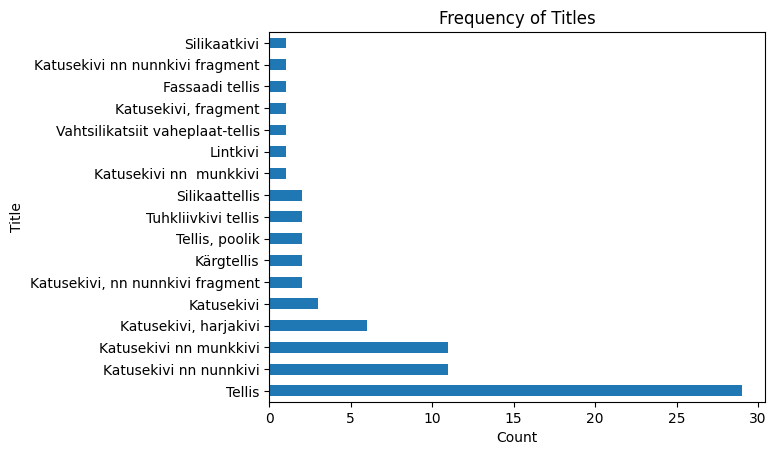

In [22]:
# @title Frequency of Titles

import matplotlib.pyplot as plt

df['Title'].value_counts().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Title')
_ = plt.title('Frequency of Titles')

**Block 4**: Making word cloud out of loaded collection data (item titles)
<br>  <font color='orange'>Action point: </font> Try changing how the word cloud is displayed (e.g. axis mode)
should find some way to modify the cloud visually

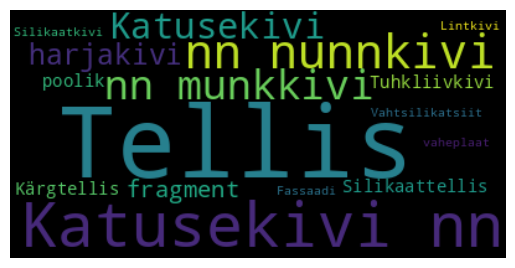

In [18]:
#Creating wordcloud based on example from:
#https://github.com/amueller/word_cloud/blob/main/examples/simple.py

#additional filtering could be applied if needed --should remove
#df = df[df['Label'].str.contains("Kleit")]
#creating a single string with all values from title column
df_joined = ' '.join(df['Title'].to_list())

#generating world cloud

# lower max_font_size
wordcloud = WordCloud(max_font_size=80).generate(df_joined)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")                                  #<--- axis display mode could be changed - should look into what exactly could be changed and what for
#displaying word cloud
plt.show()

📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓📓
<br>Let's now look into exporting MuIS content into Excel file

---

**Block 5**: Loading item details into a dataframe - choosing column that we would like to see in output (excel) file
<br>  <font color='orange'>Action point: </font> Try changing how the word cloud is displayed (e.g. axis mode)

we should explain why those specific columns are exported
people could work on it later or something

In [19]:
#filtering out values from valid URLs, adding them into multiple lists
collectionitemslist_url = []
collectionitemslist_title = []
collectionitemslist_label = []
collectionitemslist_availabiletime = []
collectionitemslist_identifier = []
collectionitemslist_publisher = []
collectionitemslist_collection = []
it = 0

for i in collectionitemslist:
    g = Graph()
    try:
        it += 1
        g.parse(i)
        for s, p, o in g:
            if "http://opendata.muis.ee/object/" in s and "www.w3.org/2000/01/rdf-schema#label" in p:  print(it), collectionitemslist_url.append(i), collectionitemslist_title.append(o)
            if "purl.org/dc/terms/available" in p:  print(it), collectionitemslist_url.append(i), collectionitemslist_availabiletime.append(o)
            if "purl.org/dc/terms/identifier" in p:  print(it), collectionitemslist_url.append(i), collectionitemslist_identifier.append(o)
            if "purl.org/dc/elements/1.1/publisher" in p:  print(it), collectionitemslist_url.append(i), collectionitemslist_publisher.append(o)
            if "http://opendata.muis.ee/object/" in s and "cidoc-crm/P46i_forms_part_of" in p and "/collection/" in o:  print(it), collectionitemslist_url.append(i), collectionitemslist_collection.append(o)
            if "rdf-schema#label" in p and "tervik" not in o:  print(it), collectionitemslist_url.append(i), collectionitemslist_label.append(o)
    except:
        pass

#making dataframe out of lists
df = pd.DataFrame(list(zip(collectionitemslist_url, collectionitemslist_title, collectionitemslist_label,
                           collectionitemslist_availabiletime, collectionitemslist_identifier, collectionitemslist_publisher, collectionitemslist_collection)))
df = df.rename(columns={0: 'URL',1: 'Title', 2: 'Label', 3: 'Made available', 4: 'Identifier', 5: 'Publisher', 6: 'Collection'})
#df = df[df['Label'].str.contains("tervik") == False]  #filtering out values with "tervik"

1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
25
25
25
25
25
25
25
26
26
26
26
26
26
26
27
27
27
27
27
27
27
27
28
28
28
28
28
28
28
29
29
29
29
29
29
29
29
30
30
30
30
30
30
30
30
30
31
31
31
31
31
31
31
31
32
32
32
32
32
32
32
32
33
33
33
33
33
33
33
34
34
34
34
34
34
34
34
35
35
35
35
35
35
35
35
36
36
36
36
36
36
36
37
37
37
37
37
37
37
38
38
38
38
38
38
38
39
39
39
39
39
39
39
40
40
40
40
40
40
40
41
41
41
41
41
41
41
42
42
42
42
42
42
42
42
43
43
43
43
43
43
43
43
44
44
44
44
44
44
44
45
45
45
45
45
45
45
46
46
46
46
46
46
46
47
47
47
47
47
47
47
47
48
4

In [20]:
df

,URL,Title,Label,Made available,Identifier,Publisher,Collection
0,http://opendata.muis.ee/object/1201359,"Katusekivi, harjakivi","Katusekivi, harjakivi",23-10-1978,TLM _ 16565:4 TE 69,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849
1,http://opendata.muis.ee/object/1201359,"Katusekivi, nn nunnkivi fragment","Harjakivi, lubja ja liiva segust vormitud, pre...",07-04-2003,TLM _ 26719 TE 74,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849
2,http://opendata.muis.ee/object/1201359,Katusekivi nn nunnkivi,"Võtmekujutis tähtedega ""SP""",15-09-1976,TLM _ 15104:5 TE 52,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849
3,http://opendata.muis.ee/object/1201359,Tellis,"Poolümara katusekivi (nn. nunnkivi) fragment, ...",15-05-1966,TLM _ 10610:5 TE 38,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849
4,http://opendata.muis.ee/object/1201359,Katusekivi nn munkkivi,"Katusekivi, nn nunnkivi fragment",01-01-1001,TLM _ 4632:2 TE 9,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849
...,...,...,...,...,...,...,...
72,http://opendata.muis.ee/object/1201966,Tellis,Rist või stiliseeritud neljalehelise ristikhei...,15-05-1966,TLM _ 10610:7 TE 40,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849
73,http://opendata.muis.ee/object/1201966,Katusekivi nn munkkivi,Punasest savist vormitud ja põletatud. Kivi ke...,15-09-1976,TLM _ 15104:10 TE 57,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849
74,http://opendata.muis.ee/object/1201966,"Katusekivi, harjakivi",Tellis,15-09-1976,TLM _ 15105:2 TE 63,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849
75,http://opendata.muis.ee/object/1201966,Katusekivi nn munkkivi,KJP 1136.,23-07-1958,TLM _ 8375 TE 20,Estonian Ministry of Culture,http://www.muis.ee/rdf/collection/849


**Block 6**: Exporting dataframe to excel file
<br>  <font color='orange'>Action point: </font> Try changing the excel file name

disppointing factopr of excel is lack of columns - we could have more
would be good to have some more columns in excel


how do we know if this things is a success
research questions:
community needs
support museums for co-creation

In [21]:
#file export out
df.to_excel("labels.xlsx")          #<--- file name could be changed
#downloading file from browser
files.download('labels.xlsx')       #<--- file name could be changed

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>